# Neural Probabilistic Language Model - Updated with Keras

**UPDATE:** This is an updated version of the original NPLM notebook. We replaced the sampled Softmax training with regular Softmax in order to allow for a comparison with the Keras implementation that is added. (And to show students how much more complicated model construction was without Keras.)


In this notebook, we'll implement the [Neural Probabilistic Language Model (Bengio et al. 2003)](http://machinelearning.wustl.edu/mlpapers/paper_files/BengioDVJ03.pdf). This model was one of the first applications of deep learning to NLP, predating `word2vec` by a whole decade! Many of the ideas in this model, however, are remarkably current - such as the skip-layer connection now popular in the form of "residual networks."

This model is a straightforward extension of n-gram language modeling: it uses a fixed context window, but instead of a table it uses a neural network to predict the next word. 

#### Note on training time
The NPLM can take a while to train on a slower machine - it was clocked it at 10-20 min on a 2-core Cloud Compute instance when the original notebook came out. 

If you're using a cloud compute instance, you can add more CPUs without having to re-do setup. With your instance turned off, go to https://console.cloud.google.com/compute/instances, click your instance, and go to "Edit". Under machine type, select "Custom" and pick 4-8 CPUs and 2 GB of RAM. Make sure you shut down when you're done, and use the Edit menu again to scale back the size to something less expensive.

In [1]:
import os, sys, re, json, time, shutil
import itertools, collections
from IPython.display import display, HTML

# NLTK for NLP utils and corpora
import nltk

# NumPy and TensorFlow
import numpy as np
import tensorflow as tf
assert(tf.__version__.startswith("2."))

# Helper libraries
from w266_common import utils, vocabulary, tf_embed_viz

## NPLM Model Architecture

Recall that our n-gram mode of order $k+1$ was:

$$ P(w_i | w_{i-1}, w_{i-2}, ..., w_0) \approx P(w_i | w_{i-1}, ..., w_{i-k}) $$

Where we estimated the probabilities by smoothed maximum likelihood.

For the NPLM, we'll replace that estimate with a neural network predictor that directly learns a mapping from contexts $(w_{i-1}, ..., w_{i-k})$ to a distribution over words $w_i$:

$$ P(w_i | w_{i-1}, ..., w_{i-k}) = f(w_i, (w_{i-1}, ..., w_{i-k})) $$

Here's what that network will look like:
![NPLM architecture](nplm.png)

Broadly, there are three parts:
1. **Embedding layer**: map words into vector space
2. **Hidden layer**: compress and apply nonlinearity
3. **Output layer**: predict next word using softmax

The model also has *skip connections* between the embedding layer and the output layer. This just means that the output layer takes as input the concatenated embeddings in addition to the hidden layer output. This was considered an unusual pattern, but has recently become popular again in the form of [Residual Networks](http://www.kaiminghe.com/icml16tutorial/icml2016_tutorial_deep_residual_networks_kaiminghe.pdf) and [Highway Networks](https://arxiv.org/abs/1505.00387).

With modern computers and a couple tricks, we should be able to get a decent model to run in just a few minutes - a far cry from the three weeks it took in 2003!

# Constructing our Model

To implement the NPLM in TensorFlow, we need to define a Tensor for each model component. To make a clear distinction between TF and non-TF code, we'll use variable names that end in an underscore for Tensor objects. We'll also construct the model so it can accept batch inputs, as this will greatly speed up training.

Hyperparameters:
- `V` : vocabulary size
- `M` : embedding size
- `N` : context window size
- `H` : hidden units

Inputs:
- `ids_` : (batch_size, N), integer indices for context words
- `y_` : (batch_size,), integer indices for target word

Model parameters:
- `C_` : (V,M), input-side word embeddings
- `W1_` : (NxM, H)
- `b1_` : (H,)
- `W2_` : (H, V)
- `W3_` : (NxM, V), matrix for skip-layer connection
- `b3_` : (V,)

Intermediate states:
- `x_` : (batch_size, NxM), concatenated embeddings
- `h_` : (batch_size, H), hidden state $= \tanh(xW_1 + b_1)$
- `logit_` : (batch_size, V), $= hW_2 + xW_3 + b_3$

In [2]:
tf.compat.v1.disable_eager_execution() #bad form - strictly for compatibility. NOT the way to do native tf2.x
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(42)

##
# Hyperparameters
V = 10000
M = 30
N = 3
H = 50

# Inputs
# Using "None" in place of batch size allows 
# it to be dynamically computed later.
with tf.compat.v1.name_scope("Inputs"):
    ids_ = tf.compat.v1.placeholder(tf.int32, shape=[None, N], name="ids")
    y_ = tf.compat.v1.placeholder(tf.int32, shape=[None], name="y")
    
with tf.compat.v1.name_scope("Embedding_Layer"):
    C_ = tf.Variable(tf.random.uniform([V, M], -1.0, 1.0), name="C")
    # embedding_lookup gives shape (batch_size, N, M)
    x_ = tf.reshape(tf.nn.embedding_lookup(params=C_, ids=ids_), 
                    [-1, N*M], name="x")
    
with tf.compat.v1.name_scope("Hidden_Layer"):
    W1_ = tf.Variable(tf.random.normal([N*M,H]), name="W1")
    b1_ = tf.Variable(tf.zeros([H,], dtype=tf.float32), name="b1")
    h_ = tf.tanh(tf.matmul(x_, W1_) + b1_, name="h")
    
with tf.compat.v1.name_scope("Output_Layer"):
    W2_ = tf.Variable(tf.random.normal([H,V]), name="W2")
    W3_ = tf.Variable(tf.random.normal([N*M,V]), name="W3")
    b3_ = tf.Variable(tf.zeros([V,], dtype=tf.float32), name="b3")
    # Concat [h x] and [W2 W3]
    hx_ = tf.concat([h_, x_], 1, name="hx")
    W23_ = tf.concat([W2_, W3_], 0, name="W23")
    logits_ = tf.add(tf.matmul(hx_, W23_), b3_, name="logits")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


We'll add in our usual cross-entropy loss. Recall from async that this is *very* slow for a large vocabulary, and even for a small vocabulary it represents the bulk of the computation time. To speed up training we'll use a sampled softmax loss, as in [Jozefowicz et al. 2016](https://arxiv.org/abs/1602.02410):

In [3]:
with tf.compat.v1.name_scope("Cost_Function"):
    # standard Softmax loss, for training
    per_example_train_loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_, logits=logits_, name="per_example_loss")
    
    # below is the original sampled softmax loss: 
    #per_example_train_loss_ = tf.nn.sampled_softmax_loss(weights=tf.transpose(a=W23_), biases=b3_,
    #                                         labels=tf.expand_dims(y_, 1), inputs=hx_,
    #                                         num_sampled=100, num_classes=V,
    #                                         name="per_example_sampled_softmax_loss")
    
    train_loss_ = tf.reduce_mean(input_tensor=per_example_train_loss_, name="softmax_loss")
    
    # Full softmax loss, for scoring
    per_example_loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_, logits=logits_, name="per_example_loss")
    loss_ = tf.reduce_mean(input_tensor=per_example_loss_, name="loss")

And add training ops. We (now) use Adam optimizer instead of vanilla SGD or Adagrad, as it tends to converge faster:

In [4]:
with tf.compat.v1.name_scope("Training"):
    alpha_ = tf.compat.v1.placeholder(tf.float32, name="learning_rate")
    #optimizer_ = tf.compat.v1.train.AdagradOptimizer(alpha_)
    optimizer_ = tf.compat.v1.train.AdamOptimizer()
    # train_step_ = optimizer_.minimize(loss_)
    train_step_ = optimizer_.minimize(train_loss_)
    
# Initializer step
init_ = tf.compat.v1.global_variables_initializer()

Finally, we'll add a few ops to do prediction:
- `pred_proba_` : (batch_size, V), $ = P(w_i | w_{i-1}, ...)$ for all words $i$
- `pred_max` : (batch_size,), id of most likely next word
- `pred_random` : (batch_size,), id of a randomly-sampled next word

In [5]:
# UPDATE: the distinction between training and prediction 
# could be removed as we now use standard softmax for training.
# But we keep this section

with tf.compat.v1.name_scope("Prediction"):
    pred_proba_ = tf.nn.softmax(logits_, name="pred_proba")
    pred_max_ = tf.argmax(input=logits_, axis=1, name="pred_max")
    pred_random_ = tf.random.categorical(logits=logits_, num_samples=1, name="pred_random")

We can use TensorBoard to view this graph, even before we run the model:

In [6]:
summary_writer = tf.compat.v1.summary.FileWriter("tf_graph", 
                                       tf.compat.v1.get_default_graph())

In a separate terminal, run:
```
tensorboard --logdir="~/w266/materials/nplm/tf_graph" --port 6006
```
and go to http://localhost:6006/

It should look something like this:
![NPLM graph](nplm-graph.png)

## Loading the Corpus

As in the original paper, we'll train on the Brown corpus. We'll pre-process the inputs as in earlier assignments, lowercasing and canonicalizing digits and adding `<s>` and `</s>` markers to sentence boundaries. See [embeddings.ipynb](../embeddings/embeddings.ipynb) for more details.

We'll also restrict our vocabulary to the top 10,000 words. 

_**Exercise:**_ why do we need a fixed-size vocabulary for our neural model? And why does it help to restrict its size?

In [3]:
corpus_name = "brown"
V = 10000

vocab, train_ids, test_ids = utils.load_corpus(corpus_name, split=0.8, V=V, shuffle=False)

[nltk_data] Downloading package brown to /home/mhbutler/nltk_data...
[nltk_data]   Package brown is already up-to-date!


Vocabulary: 10,000 types
Loaded 57,340 sentences (1.16119e+06 tokens)
Training set: 45,872 sentences (979,646 tokens)
Test set: 11,468 sentences (181,546 tokens)


Our model is designed to accept batches of data, so we need to do a little re-formatting. We want our input batches to look like the following, where the first $N$ columns are the inputs and the last is the target word:

In [4]:
##
# Hyperparameters
V = 10000
M = 30
N = 3
H = 50



cols = ["w_{i-%d}" % d for d in range(N,0,-1)] + ["target: w_i"]
M = np.array([[0,3,5613,655], [3,5613,655,2288], [5613,655,2288,1640]])
utils.pretty_print_matrix(M, cols=cols, dtype=int)

,w_{i-3},w_{i-2},w_{i-1},target: w_i
0,0,3,5613,655
1,3,5613,655,2288
2,5613,655,2288,1640


We'll format our entire corpus like this, and then we can just sample blocks from it to get our training minibatches. The code for this is in `utils.py`, but you can view it in-notebook by running the cell below:

In [5]:
train_windows = utils.build_windows(train_ids, N)
test_windows = utils.build_windows(test_ids, N)

# Check that we got what we want
# Just look at the first few IDs for this sample
utils.pretty_print_matrix(utils.build_windows(train_ids[:(N+5)], N, shuffle=False), cols=cols, dtype=int)

,w_{i-3},w_{i-2},w_{i-1},target: w_i
0,0,3,5405,652
1,3,5405,652,2287
2,5405,652,2287,1628
3,652,2287,1628,65
4,2287,1628,65,1837


## Training time without Keras!

With our data in array form, we can train our model much like any machine learning model. The code below should look familiar to the `train_nn` function from Assignment 1. We'll factor out a few operations into helpers, so that the basic structure is clearer.

In [10]:
##
# Helper functions for training
def train_batch(session, batch, alpha):
    # Feed last column as targets
    feed_dict = {ids_:batch[:,:-1],
                 y_:batch[:,-1],
                 alpha_:alpha}
    c, _ = session.run([train_loss_, train_step_],
                       feed_dict=feed_dict)
    return c

## We'll use this to generate the batches.
#utils.batch_generator??

Training a single epoch should take around 6-7 minutes on a 2-core Cloud Compute instance, or around 30 seconds on a GTX 980 GPU. You should get good results after just 5 epochs with a train loss around 5.0. (Note that this does not compare to the original implementation with sampled softmax, as the loss function is different!)

Rememer that the cost printed is the average *training* loss. Since we're using the sampled softmax, this will be an underestimate of the true loss. We'll need to do a separate run over the data to compute perplexity.

In [11]:
# One epoch = one pass through the training data
num_epochs = 5
batch_size = 100
alpha = 0.5  # learning rate
print_every = 1000

np.random.seed(42)

session = tf.compat.v1.Session()
session.run(init_)

t0 = time.time()
#for epoch in xrange(1,num_epochs+1):
for epoch in range(1,num_epochs+1):
    t0_epoch = time.time()
    epoch_cost = 0.0
    total_batches = 0
    print("")
    for i, batch in enumerate(utils.batch_generator(train_windows, batch_size)):
        if (i % print_every == 0):
            print('[epoch %d] seen %d minibatches' % (epoch,i))
        
        epoch_cost += train_batch(session, batch, alpha)
        total_batches = i + 1

    avg_cost = epoch_cost / total_batches

    print('[epoch %d] Completed %d minibatches in %s' % (epoch, i, utils.pretty_timedelta(since=t0_epoch)))
    print('[epoch %d] Average cost: %.03f' % (epoch, avg_cost,))


[epoch 1] seen 0 minibatches
[epoch 1] seen 1000 minibatches
[epoch 1] seen 2000 minibatches
[epoch 1] seen 3000 minibatches
[epoch 1] seen 4000 minibatches
[epoch 1] seen 5000 minibatches
[epoch 1] seen 6000 minibatches
[epoch 1] seen 7000 minibatches
[epoch 1] seen 8000 minibatches
[epoch 1] seen 9000 minibatches
[epoch 1] seen 10000 minibatches
[epoch 1] Completed 10255 minibatches in 0:00:34
[epoch 1] Average cost: 11.708

[epoch 2] seen 0 minibatches
[epoch 2] seen 1000 minibatches
[epoch 2] seen 2000 minibatches
[epoch 2] seen 3000 minibatches
[epoch 2] seen 4000 minibatches
[epoch 2] seen 5000 minibatches
[epoch 2] seen 6000 minibatches
[epoch 2] seen 7000 minibatches
[epoch 2] seen 8000 minibatches
[epoch 2] seen 9000 minibatches
[epoch 2] seen 10000 minibatches
[epoch 2] Completed 10255 minibatches in 0:00:34
[epoch 2] Average cost: 5.886

[epoch 3] seen 0 minibatches
[epoch 3] seen 1000 minibatches
[epoch 3] seen 2000 minibatches
[epoch 3] seen 3000 minibatches
[epoch 3] see

# Scoring

We'll score our model the same as the n-gram model, by computing perplexity over the dev set. Recall that perplexity is just the exponentiated average cross-entropy loss:

$$ \text{Perplexity} = \left( \prod_i \frac{1}{Q(x_i)} \right)^{1/N} = \left( \prod_i 2^{- \log_2 Q(x_i)} \right)^{1/N} = 2^{\left(\frac{1}{N} \sum_i -\log_2 Q(x_i)\right)} = 2^{\tilde{CE}(P,Q)}$$

In practice TF uses the natural log, so the loss will be scaled by a factor of $\ln 2$ - but the base cancels and the perplexity scores will be the same.

Note that below we use `loss_`, which is the cross-entropy loss with the full softmax. Because this is so much slower than the sampled softmax, on a slower machine the scoring step might take as long or longer than training!

In [12]:
def score_batch(session, batch):
    feed_dict = {ids_:batch[:,:-1],
                 y_:batch[:,-1]}
    return session.run(loss_, feed_dict=feed_dict)

def score_dataset(data):
    total_cost = 0.0
    total_batches = 0
    for batch in utils.batch_generator(data, 1000):
        total_cost += score_batch(session, batch)
        total_batches += 1

    return total_cost / total_batches

In [13]:
print("Train set perplexity: %.03f" % np.exp(score_dataset(train_windows)))
print("Test set perplexity: %.03f" % np.exp(score_dataset(test_windows)))

Train set perplexity: 131.906
Test set perplexity: 191.061


Looks pretty good! Note that these numbers aren't directly comparable to the literature, since we made the task easier by lowercasing everything, canonicalizing digits, and treating a fairly large number of words as an `<unk>` token.

We can remove some of this handicap by looking at our perplexity on non-`<unk>` target words:

In [14]:
filtered_test_windows = test_windows[test_windows[:,-1] != vocab.UNK_ID]
print("Filtered test set perplexity: %.03f" % np.exp(score_dataset(filtered_test_windows)))

Filtered test set perplexity: 226.565


Note that the perplexity scores are better than in the original NPLM notebook.

# Sampling

We can sample sentences from the model much as we did with n-gram models. We'll use the `pred_random_` op that we defined before:

In [15]:
def predict_next(session, seq):
    feed_dict={ids_:np.array([seq[-N:]])}
    next_id = session.run(pred_random_, feed_dict=feed_dict)
    return next_id[0][0]

def score_seq(session, seq):
    # Some gymnastics to generate windows for scoring
    windows = [seq[i:i+N+1] for i in range(len(seq)-(N+1))]
    return score_batch(session, np.array(windows))

max_length = 30
num_sentences = 5

for _ in range(num_sentences):
    seq = [vocab.word_to_id["<s>"]]*N  # init N+1-gram model
    for i in range(max_length):
        seq.append(predict_next(session, seq))
        if seq[-1] == vocab.word_to_id["<s>"]: break
    print(" ".join(vocab.ids_to_words(seq)))
    score = score_seq(session, seq)
    print ("[%d tokens; log P(seq): %.02f, per-token: %.02f]" % (len(seq), score, score/(len(seq)-2)))
    print("")

<s> <s> <s> these are the concept of my case where they are one work of the subject which russia would seem <unk> no <unk> to <unk> plaster it's important , and do
[33 tokens; log P(seq): 4.87, per-token: 0.16]

<s> <s> <s> when you should emphasize it <unk> . <s>
[11 tokens; log P(seq): 4.20, per-token: 0.47]

<s> <s> <s> the <unk> wishes of <unk> , whether birthday ; ; <s>
[14 tokens; log P(seq): 4.48, per-token: 0.37]

<s> <s> <s> unlimited queen of the <unk> <unk> , <unk> appealed catch from the sun district life and wisely , the name had not been residence , animals should have a ignorant
[33 tokens; log P(seq): 5.38, per-token: 0.17]

<s> <s> <s> even were done by the results of the natural body colonel a <unk> and <unk> . <s>
[20 tokens; log P(seq): 4.25, per-token: 0.24]



# "Same Procedure as Last Year" - but with Keras

Let's import a couple of libraries for the model visualization.

In [6]:
import pydot
import graphviz

### Input Preparation:

Let's convert the windows into suitable Keras test and training data:

In [7]:
train_X = np.array([list(x[:-1]) for x in train_windows])
train_Y = np.array([[x[-1]] for x in train_windows])

test_X = np.array([list(x[:-1]) for x in test_windows])
test_Y = np.array([[x[-1]] for x in test_windows])

In [8]:
train_X

array([[ 193,   12,   99],
       [1973, 9099,    5],
       [  17,   40,    0],
       ...,
       [   2,  247,   55],
       [5946,   55,  494],
       [   8,   98,    4]])

In [9]:
train_Y

array([[59],
       [ 0],
       [60],
       ...,
       [67],
       [63],
       [11]])

Looks good!

### Model Construction

Since this is not a sequential model due to the skipped connections, we have to use Keras' Functional API to construct the model. (This approach is much more flexible than the Sequential model anyway.)  

To construct a model with the Functional API, the key steps are:

* Define the input(s) with Input layer(s)   
* Define the output of future layers as 'layer acting on input)
* Define the output layer(s)
* Tie the model together through specifying input and output layers
* Compile the model by specifying loss(es), optimizer, metric(s), etc.

In [10]:
tf.keras.backend.clear_session()

def model_creation(V, M, H, N, activation, skip_connection=True):

    ##

    # input layer
    input_id = tf.keras.layers.Input(shape=(N), name='inputs')

    # embedding layer. Remember, in Functional API:
    #   layer_output = layer(layer_input)
    embedding_layer = tf.keras.layers.Embedding(input_dim=V, 
                                                output_dim=M, 
                                                name='embedding')
    embeddings = embedding_layer(input_id)

    # concatenation
    # Since Keras Concatenate layer assumes a list of inputs, we split the embedding tensor
    concatenation_input_layer = tf.keras.layers.Concatenate(axis=-1, name='concatenation_input')
    split_embeddings = tf.split(embeddings, num_or_size_splits=N, axis=1)
    concatenation_input = concatenation_input_layer(split_embeddings) 

    # There is a dimension too many. Let's remove the extra 'times 1' by reshaping 
    reshaped_input = tf.keras.layers.Reshape((N*M,), name='Reshape')(concatenation_input)

    # hidden layer
    hidden = tf.keras.layers.Dense(H, activation=activation, name='hidden')(reshaped_input)

    if skip_connection:
        # concatenation of hidden layer output and the properly shaped input
        concatenation_output_layer = tf.keras.layers.Concatenate(axis=-1, name='concatenation_output')
        concatenation_output = concatenation_output_layer([hidden, reshaped_input])
    else:
        # name is now misleading, but let's ignore that
        concatenation_output = hidden

    # logits
    logits = tf.keras.layers.Dense(V, activation='linear', name='logits')(concatenation_output)

    # softmax
    probabilities = tf.keras.layers.Softmax(name='softmax')(logits)

    ## 'Tieing the model together'

    functional_keras_model = tf.keras.Model(inputs=input_id, outputs=probabilities, name="keras_model")

    ## Model compile, specifying loss(es), optimizer, and metric(s)

    functional_keras_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"],
    )
    
    return functional_keras_model


In [11]:
V = 10000             # vocabulary size
M = 30                # embedding size
H = 50                # dimension of hidden layer
activation = 'tanh'   # activation function in hidden layer

base_keras_model = model_creation(V=V, M=M, H=H, N=3, activation=activation)

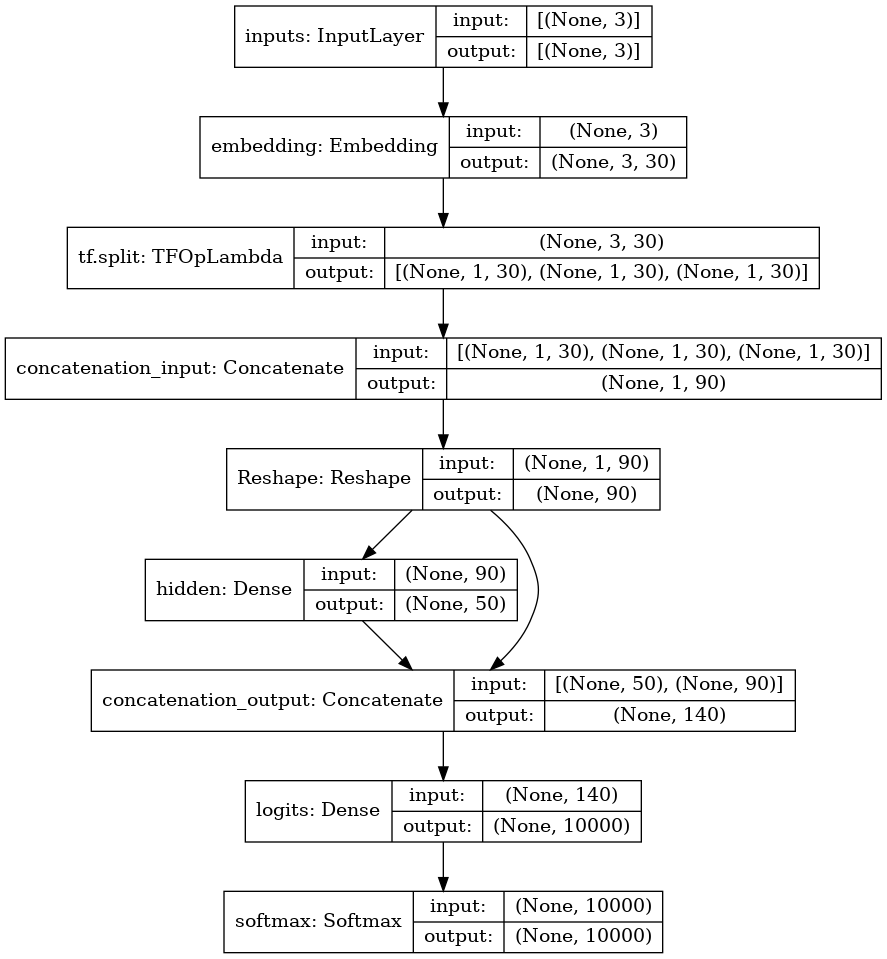

In [12]:
tf.keras.utils.plot_model(base_keras_model, "NPLM.png", show_shapes=True)

### Model Training

Let's now fit the model:

In [13]:
history = base_keras_model.fit(train_X,
                           train_Y,
                           validation_data=(test_X, test_Y),
                           epochs=3,
                           batch_size=100)

Epoch 1/3
10256/10256 [==============================] - 536s 52ms/step - loss: 5.3872 - accuracy: 0.1989 - val_loss: 4.9597 - val_accuracy: 0.2155
Epoch 2/3
10256/10256 [==============================] - 542s 53ms/step - loss: 4.9511 - accuracy: 0.2266 - val_loss: 4.8887 - val_accuracy: 0.2163
Epoch 3/3
10256/10256 [==============================] - 537s 52ms/step - loss: 4.7907 - accuracy: 0.2343 - val_loss: 4.8566 - val_accuracy: 0.2213


Good to see that we apparently did not over-train all that much.

(Keras operates a bit differently. Also, we didn't bother to make sure we match all of the tuning parameters, so we simply adjusted the number of epochs to roughly match overall training time. But it is not exactly an apples-to-apples comparison, hence the better loss.)

### Perplexities

In [14]:
def perplexity(model, X, Y, batch_size):
    count = 0
    cross_entropy = 0

    for batch_start in range(1, X.shape[0], batch_size):
        if (count + 1) * batch_size > X.shape[0]:
            print('Batches calculated: ', count)
            continue
        batch_entropy = 0
        train_preds = model.predict(X[batch_start:batch_start + batch_size])
        actuals = Y[batch_start:batch_start + batch_size]

        for example in range(batch_size):
            actual = actuals[example][0]
            q = train_preds[example, actual]
            batch_entropy -= np.log(q)

        cross_entropy += batch_entropy/batch_size
        
        count += 1
        
        if count % 100 == 0:
            print('Batches calculated: ', count)

    cross_entropy = cross_entropy/count
    perplexity = np.exp(cross_entropy)
    
    return cross_entropy, perplexity
    
    

In [15]:
train_cross_entropy, train_perplexity = perplexity(base_keras_model, train_X, train_Y, batch_size=1000)

Batches calculated:  100
Batches calculated:  200
Batches calculated:  300
Batches calculated:  400
Batches calculated:  500
Batches calculated:  600
Batches calculated:  700
Batches calculated:  800
Batches calculated:  900
Batches calculated:  1000
Batches calculated:  1025


In [16]:
print('Train Cross-Entropy: ', train_cross_entropy)
print('Train Perplexity: ', train_perplexity)

Train Cross-Entropy:  4.601307839532605
Train Perplexity:  99.6145102810949


In [17]:
test_cross_entropy, test_perplexity = perplexity(base_keras_model, test_X, test_Y, batch_size=1000)
print('Test Cross-Entropy: ', test_cross_entropy)
print('Test Perplexity: ', test_perplexity)

Batches calculated:  100
Batches calculated:  193
Test Cross-Entropy:  4.85672703595125
Test Perplexity:  128.60260085169816


Very good! Again, we certainly could have gotten a similar result using non-Keras TensorFlow with more attention to training parameters. But appreciate the much easier implementation. Essentially, you implemented here - with the benefit of tremendous open source work - a paper with 7000+ citations in a few lines of pretty clear code. (Of course, the paper really shines through its insights which were tremendous in 2003.)

### Experiments

#### Larger Context Window 

Let us see whether a larger context (N=5) affects the perplexity favorably.

First, we need to create new train data: 

In [18]:
N = 5

train_windows = utils.build_windows(train_ids, N)
test_windows = utils.build_windows(test_ids, N)

# Check that we got what we want
# Just look at the first few IDs for this sample
#utils.pretty_print_matrix(utils.build_windows(train_ids[:(N+5)], N, shuffle=False), cols=cols, dtype=int)

In [19]:
train_X = np.array([list(x[:-1]) for x in train_windows])
train_Y = np.array([[x[-1]] for x in train_windows])

test_X = np.array([list(x[:-1]) for x in test_windows])
test_Y = np.array([[x[-1]] for x in test_windows])

In [20]:
train_X

array([[ 706,  183, 2073,   26,    3],
       [   3,  550,    6,  194,  572],
       [ 793,    6, 1694,   17,    5],
       ...,
       [ 681,   24,   24,    0,   31],
       [ 226,   24,   24,    0,  174],
       [   3,  334,    7,    3, 3686]])

In [21]:
train_Y

array([[ 752],
       [   2],
       [   0],
       ...,
       [ 106],
       [6083],
       [  32]])

Looks good.

Now we meed to define the new model and then train it:

In [22]:
V = 10000             # vocabulary size
M = 30                # embedding size
H = 50                # dimension of hidden layer
activation = 'tanh'   # activation function in hidden layer

N_5_keras_model = model_creation(V=V, M=M, H=H, N=5, activation=activation)

In [23]:
history_N_5 = N_5_keras_model.fit(train_X,
                           train_Y,
                           validation_data=(test_X, test_Y),
                           epochs=3,
                           batch_size=100)

Epoch 1/3
10256/10256 [==============================] - 649s 63ms/step - loss: 5.3837 - accuracy: 0.2012 - val_loss: 4.9369 - val_accuracy: 0.2191
Epoch 2/3
10256/10256 [==============================] - 649s 63ms/step - loss: 4.8944 - accuracy: 0.2305 - val_loss: 4.8516 - val_accuracy: 0.2240
Epoch 3/3
10256/10256 [==============================] - 652s 64ms/step - loss: 4.6896 - accuracy: 0.2383 - val_loss: 4.8470 - val_accuracy: 0.2285


Better train loss and metric, and marginally better test loss and metric (barely). Let's look at perplexity:

In [34]:
train_cross_entropy, train_perplexity = perplexity(N_5_keras_model, train_X, train_Y, batch_size=1000)
test_cross_entropy, test_perplexity = perplexity(N_5_keras_model, test_X, test_Y, batch_size=1000)

print('Train Cross-Entropy: ', train_cross_entropy)
print('Train Perplexity: ', train_perplexity)

print('Test Cross-Entropy: ', test_cross_entropy)
print('Test Perplexity: ', test_perplexity)


Batches calculated:  100
Batches calculated:  200
Batches calculated:  300
Batches calculated:  400
Batches calculated:  500
Batches calculated:  600
Batches calculated:  700
Batches calculated:  800
Batches calculated:  900
Batches calculated:  1000
Batches calculated:  1025
Batches calculated:  100
Batches calculated:  193
Train Cross-Entropy:  4.442702483338064
Train Perplexity:  85.00435439358856
Test Cross-Entropy:  4.853296812155193
Test Perplexity:  128.16222088275467


Again... barely better for the test set. But a bit.

#### Relu vs Tanh

In [35]:
activation = 'relu'   # activation function in hidden layer

N_5_relu_keras_model = model_creation(V=V, M=M, H=H, N=5, activation=activation)

In [36]:
history_N_5_relu = N_5_relu_keras_model.fit(train_X,
                           train_Y,
                           validation_data=(test_X, test_Y),
                           epochs=3,
                           batch_size=100)

Train on 1025514 samples, validate on 193010 samples
Epoch 1/3
1025514/1025514 [==============================] - 63s 61us/sample - loss: 5.4159 - accuracy: 0.2003 - val_loss: 4.9708 - val_accuracy: 0.2191
Epoch 2/3
1025514/1025514 [==============================] - 63s 61us/sample - loss: 4.9121 - accuracy: 0.2290 - val_loss: 4.9040 - val_accuracy: 0.2265
Epoch 3/3
1025514/1025514 [==============================] - 63s 61us/sample - loss: 4.6922 - accuracy: 0.2373 - val_loss: 4.9362 - val_accuracy: 0.2275


In [37]:
train_cross_entropy, train_perplexity = perplexity(N_5_relu_keras_model, train_X, train_Y, batch_size=1000)
test_cross_entropy, test_perplexity = perplexity(N_5_relu_keras_model, test_X, test_Y, batch_size=1000)

print('Train Cross-Entropy: ', train_cross_entropy)
print('Train Perplexity: ', train_perplexity)

print('Test Cross-Entropy: ', test_cross_entropy)
print('Test Perplexity: ', test_perplexity)

Batches calculated:  100
Batches calculated:  200
Batches calculated:  300
Batches calculated:  400
Batches calculated:  500
Batches calculated:  600
Batches calculated:  700
Batches calculated:  800
Batches calculated:  900
Batches calculated:  1000
Batches calculated:  1025
Batches calculated:  100
Batches calculated:  193
Train Cross-Entropy:  4.4444010031249706
Train Perplexity:  85.14885865843495
Test Cross-Entropy:  4.936104683134078
Test Perplexity:  139.2268591754965


This (one) test did not show improvement

#### No Skip-Connection

Let's see whether the skip connection was critical:

In [38]:
N_5_no_skip_keras_model = model_creation(V=V, M=M, H=H, N=5, activation='tanh', skip_connection=False)

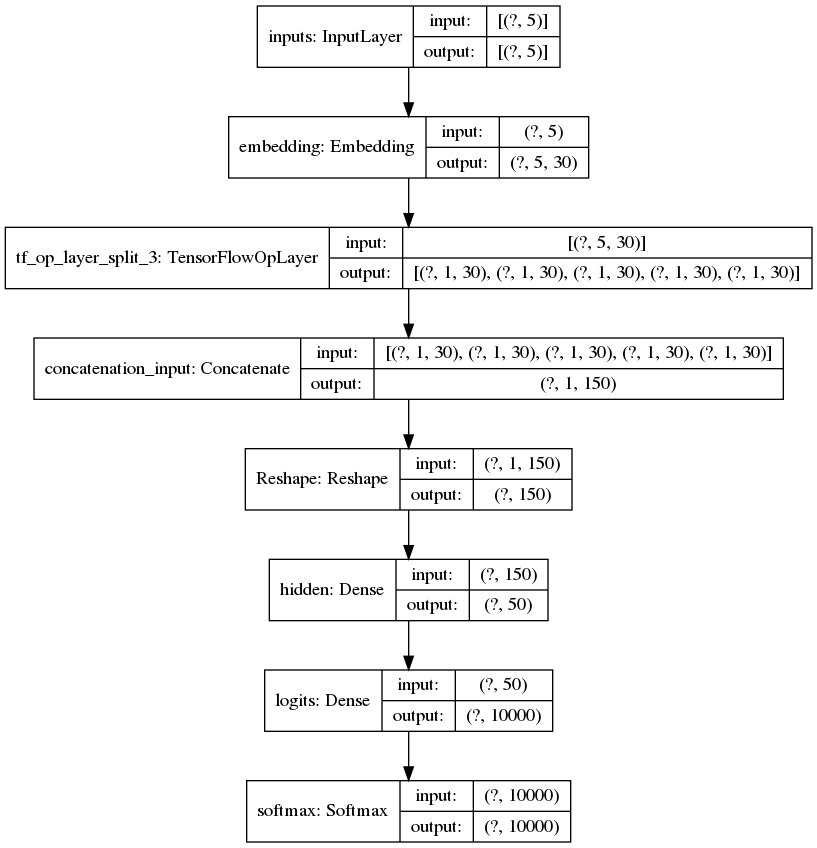

In [39]:
tf.keras.utils.plot_model(N_5_no_skip_keras_model, "NPLM_no_skip.png", show_shapes=True)

Looks right. Now let's run the machinery.

In [40]:
history_N_5_no_skip = N_5_no_skip_keras_model.fit(train_X,
                           train_Y,
                           validation_data=(test_X, test_Y),
                           epochs=3,
                           batch_size=100)

Train on 1025514 samples, validate on 193010 samples
Epoch 1/3
1025514/1025514 [==============================] - 60s 58us/sample - loss: 5.4875 - accuracy: 0.1905 - val_loss: 5.0354 - val_accuracy: 0.2101
Epoch 2/3
1025514/1025514 [==============================] - 59s 58us/sample - loss: 5.0625 - accuracy: 0.2238 - val_loss: 4.9049 - val_accuracy: 0.2202
Epoch 3/3
1025514/1025514 [==============================] - 59s 58us/sample - loss: 4.9089 - accuracy: 0.2339 - val_loss: 4.8594 - val_accuracy: 0.2236


In [41]:
train_cross_entropy, train_perplexity = perplexity(N_5_no_skip_keras_model, train_X, train_Y, batch_size=1000)
test_cross_entropy, test_perplexity = perplexity(N_5_no_skip_keras_model, test_X, test_Y, batch_size=1000)

print('Train Cross-Entropy: ', train_cross_entropy)
print('Train Perplexity: ', train_perplexity)

print('Test Cross-Entropy: ', test_cross_entropy)
print('Test Perplexity: ', test_perplexity)

Batches calculated:  100
Batches calculated:  200
Batches calculated:  300
Batches calculated:  400
Batches calculated:  500
Batches calculated:  600
Batches calculated:  700
Batches calculated:  800
Batches calculated:  900
Batches calculated:  1000
Batches calculated:  1025
Batches calculated:  100
Batches calculated:  193
Train Cross-Entropy:  4.755762686627323
Train Perplexity:  116.252283423509
Test Cross-Entropy:  4.859327171680468
Test Perplexity:  128.93742016824226


Interesting! Not as good on the training set but essentially equal for the test set! Maybe the skip layer was not as critical in this instance? 


### Larger Embedding and Hidden Sizes

In [53]:
V = 10000             # vocabulary size
M = 60                # embedding size
H = 200                # dimension of hidden layer
activation = 'tanh'   # activation function in hidden layer

N_5_keras_model_big = model_creation(V=V, M=M, H=H, N=5, activation=activation)

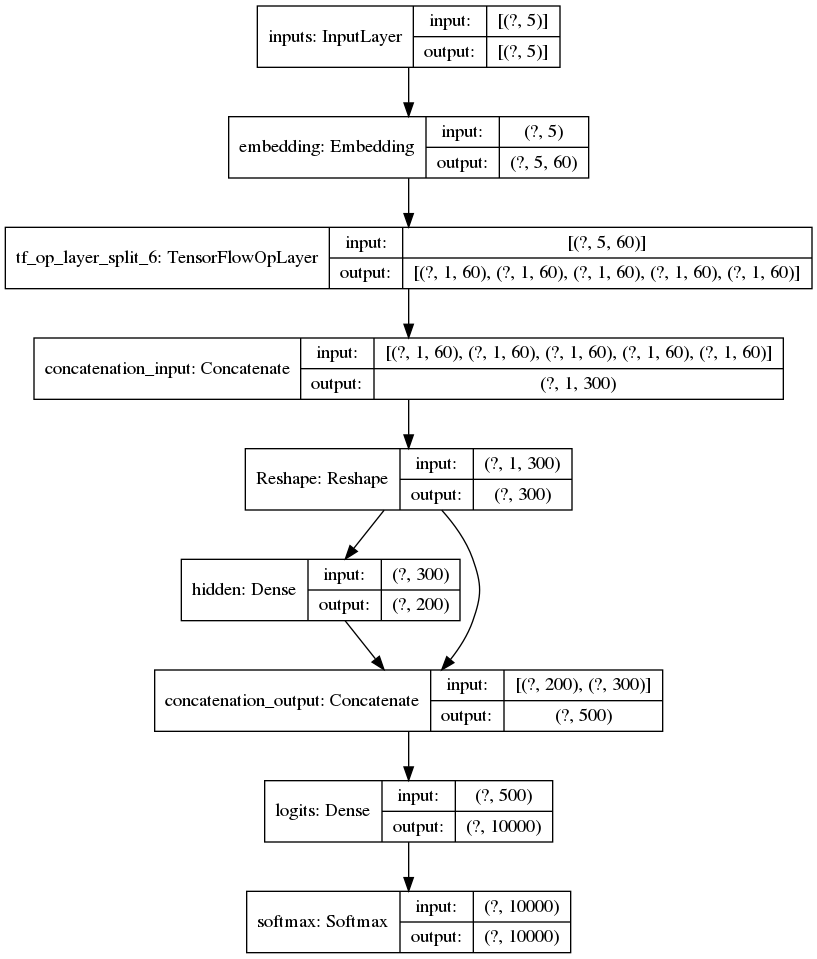

In [54]:
tf.keras.utils.plot_model(N_5_keras_model_big, "NPLM_big.png", show_shapes=True)

In [55]:
history_N_5_big = N_5_keras_model_big.fit(train_X,
                           train_Y,
                           validation_data=(test_X, test_Y),
                           epochs=2,                          # ~ compensating for longer epoch run time
                           batch_size=100)

Train on 1025514 samples, validate on 193010 samples
Epoch 1/2
1025514/1025514 [==============================] - 80s 78us/sample - loss: 5.2719 - accuracy: 0.2091 - val_loss: 4.8622 - val_accuracy: 0.2225
Epoch 2/2
1025514/1025514 [==============================] - 80s 78us/sample - loss: 4.7451 - accuracy: 0.2363 - val_loss: 4.8302 - val_accuracy: 0.2273


In [56]:
train_cross_entropy, train_perplexity = perplexity(N_5_keras_model_big, train_X, train_Y, batch_size=1000)
test_cross_entropy, test_perplexity = perplexity(N_5_keras_model_big, test_X, test_Y, batch_size=1000)

print('Train Cross-Entropy: ', train_cross_entropy)
print('Train Perplexity: ', train_perplexity)

print('Test Cross-Entropy: ', test_cross_entropy)
print('Test Perplexity: ', test_perplexity)

Batches calculated:  100
Batches calculated:  200
Batches calculated:  300
Batches calculated:  400
Batches calculated:  500
Batches calculated:  600
Batches calculated:  700
Batches calculated:  800
Batches calculated:  900
Batches calculated:  1000
Batches calculated:  1025
Batches calculated:  100
Batches calculated:  193
Train Cross-Entropy:  4.321322444330431
Train Perplexity:  75.28812684336754
Test Cross-Entropy:  4.830128798212836
Test Perplexity:  125.2270886413306


A tad better. We may be very close to over-training though. (How well could you do here with regularization?) 



**Note:** all of these tests are to be taken with a grain of salt. But they illustrate (some) of the types of experiments you may want to do in your projects.